# Comparison of HPE MPT and Intel MPI Performance

Using Cirrus

In [1]:
import re
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white", {"font.family": "serif"})
sns.set_context("paper")

In [2]:
def getbeffres(resfilename):
    infile = open(resfilename, 'r')
    pingpong = {}
    randring = {}
    natring = {}
    indata = False
    nline = 0
    for line in infile:
        if indata:
            nline += 1
            if nline == 2:
                # pp latency, e.g.:
                # Latency   min / avg / max:   0.001237 /   0.001749 /   0.004679 msecs
                line = line.strip()
                tokens = line.split()
                pingpong['min_lat'] = float(tokens[6])
                pingpong['mean_lat'] = float(tokens[8])
                pingpong['max_lat'] = float(tokens[10])
            elif nline == 3:
                # pp bw, e.g.:
                # Bandwidth min / avg / max:   3053.734 /   7057.902 /   8909.833 MByte/s
                line = line.strip()
                tokens = line.split()
                pingpong['min_bw'] = float(tokens[6])
                pingpong['mean_bw'] = float(tokens[8])
                pingpong['max_bw'] = float(tokens[10])
            elif nline == 5:
                # nat ring, e.g.:
                # On naturally ordered ring: latency= 0.001597 msec, bandwidth= 3773.552857 MB/s
                line = line.strip()
                tokens = line.split()
                randring['lat'] = float(tokens[5])
                randring['bw'] = float(tokens[8])
            elif nline == 6:
                # rand ring, e.g:
                # On randomly  ordered ring: latency= 0.003608 msec, bandwidth= 4065.500726 MB/s
                natring['lat'] = float(tokens[5])
                natring['bw'] = float(tokens[8])
                break
        else:
            if re.match('Detailed', line):
                indata = True
                nline = 0

    infile.close()

    return pingpong, randring, natring

In [3]:
def calcperf(filedict, cpn, restype='rr'):
    coreslist = []
    bw = []
    lat = []
    if restype == 'rr':
        print("Random Ring results:")
    elif restype == 'nr':
        print("Random Ring results:")
    print("{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'BW (GiB/s)', 'Lat. (us)'))
    print("{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '==========', '========='))
    for nodes, filename in sorted(filedict.items()):
        pp, rr, nr = getbeffres(filename)
        coreslist.append(nodes*cpn)
        tbw = None
        tlat = None
        if restype == 'rr':
            tbw = rr['bw']/1024.0
            tlat = rr['lat']*1000
        if restype == 'nr':
            tbw = nr['bw']/1024.0
            tlat = nr['lat']*1000
        bw.append(tbw)
        lat.append(tlat)
        print("{:>15d} {:>15d} {:>15.3f} {:>15.3f}".format(nodes, nodes*cpn, tbw, tlat))
    return coreslist, bw, lat

In [4]:
mptfiles = {2:'../beff_results/Cirrus/MPT214/nodes2ppn36_201709182205_hpccoutf.txt',
               4:'../beff_results/Cirrus/MPT214/nodes4ppn36_201709182205_hpccoutf.txt',
               8:'../beff_results/Cirrus/MPT214/nodes8ppn36_201709182204_hpccoutf.txt',
               16:'../beff_results/Cirrus/MPT214/nodes16ppn36_201709182203_hpccoutf.txt',
               32:'../beff_results/Cirrus/MPT214/nodes32ppn36_201709182202_hpccoutf.txt'}

In [5]:
cirruscpn = 36
mptcores, mpt_rrbw, mpt_rrlat = calcperf(mptfiles, cirruscpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              72           1.636           0.933
              4             144           1.406           1.115
              8             288           1.365           1.078
             16             576           1.339           1.285
             32            1152           1.339           1.459


In [9]:
impifiles = {2:'../beff_results/Cirrus/IMPI17/nodes2ppn36_201801091541_hpccoutf.txt',
               4:'../beff_results/Cirrus/IMPI17/nodes4ppn36_201801091540_hpccoutf.txt',
               8:'../beff_results/Cirrus/IMPI17/nodes8ppn36_201801091539_hpccoutf.txt',
               16:'../beff_results/Cirrus/IMPI17/nodes16ppn36_201801091538_hpccoutf.txt',
               32:'../beff_results/Cirrus/IMPI17/nodes32ppn36_201801091535_hpccoutf.txt'}

In [10]:
impicores, impi_rrbw, impi_rrlat = calcperf(impifiles, cirruscpn, restype='rr')

Random Ring results:
          Nodes           Cores      BW (GiB/s)       Lat. (us)
          =====           =====      ==========       =========
              2              72           1.904           1.502
              4             144           1.181           1.407
              8             288           0.409           1.597
             16             576           0.297           1.884
             32            1152           0.158           2.003


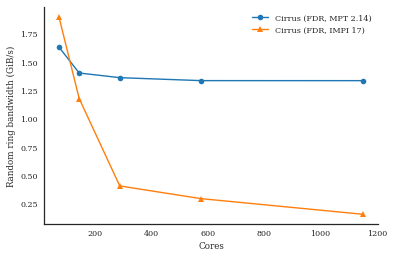

In [11]:
plt.plot(mptcores, mpt_rrbw, 'o-', label='Cirrus (FDR, MPT 2.14)')
plt.plot(impicores, impi_rrbw, '^-', label='Cirrus (FDR, IMPI 17)')
plt.xlabel('Cores')
plt.ylabel('Random ring bandwidth (GiB/s)')
plt.legend(loc='best')
sns.despine()

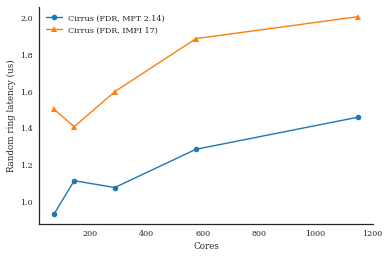

In [12]:
plt.plot(mptcores, mpt_rrlat, 'o-', label='Cirrus (FDR, MPT 2.14)')
plt.plot(impicores, impi_rrlat, '^-', label='Cirrus (FDR, IMPI 17)')
plt.xlabel('Cores')
plt.ylabel('Random ring latency (us)')
plt.legend(loc='best')
sns.despine()